In [2]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

# globally silence FutureWarning messages
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
otu_path = r"C:\Users\aburg\Documents\calculations\rmqs_exploration\data\rmqs1_16S_otu_abundance.tsv.gz"
otu_df = pd.read_csv(otu_path, sep="\t", index_col="id_site", compression="gzip", low_memory=False, encoding='windows-1252')
otu_df.index = otu_df.index.astype(str)

In [4]:
metadata_path = r"C:\Users\aburg\Documents\calculations\rmqs_exploration\data\RMQS1_occupation_nommatp_nomsol_23_03_2022.csv"
metadata_df = pd.read_csv(metadata_path, index_col="id_site", encoding='windows-1252')
metadata_df.index = metadata_df.index.astype(str)
metadata_df.columns

Index(['no_campagne', 'date_complete', 'insee_commune', 'nom_commune',
       'code_dept', 'site_officiel', 'x_theo', 'y_theo',
       'classe_mat1p_million_dexpert', 'libelle_mat1p_million_dexpert',
       'classe_mat2p_million_dexpert', 'libelle_mat2p_million_dexpert',
       'classe_mat3p_million_dexpert', 'libelle_mat3p_million_dexpert',
       'rp_95_nom', 'rp_2008_nom', 'rp_95_ger', 'signific_ger_95',
       'rp_2008_ger', 'signific_ger_2008', 'occupation1',
       'desc_code_occupation1', 'occupation3', 'desc_code_occupation3'],
      dtype='object')

In [17]:
metadata_df.head()

,no_campagne,date_complete,insee_commune,nom_commune,code_dept,site_officiel,x_theo,y_theo,classe_mat1p_million_dexpert,libelle_mat1p_million_dexpert,...,rp_95_nom,rp_2008_nom,rp_95_ger,signific_ger_95,rp_2008_ger,signific_ger_2008,occupation1,desc_code_occupation1,occupation3,desc_code_occupation3
id_site,,,,,,,,,,,,,,,,,,,,,
6,1,10/09/2002,59016,ARMBOUTS-CAPPEL,59,True,652326.99,7101219.71,120,Estuarine/Marine alluvium,...,"THALASSOSOL-REDOXISOL limono-sablo-argileux, b...",ND,156,THALASSOSOL-REDOXISOL,ND,ND,1,successions culturales,120,grandes cultures et prairies courte duree
7,1,02/09/2002,59404,LES MOERES,59,True,668319.25,7101085.53,120,Estuarine/Marine alluvium,...,THALASSOSOL-REDOXISOL limoneux issu d'alluvion...,ND,156,THALASSOSOL-REDOXISOL,ND,ND,1,successions culturales,112,systeme de rotations sans prairie sans intercu...
8,1,02/07/2003,62806,TARDINGHEN,62,True,604216.81,7085629.01,230,Marl,...,"CALCOSOL-REDOXISOL argileux, issu d'une marne,...",ND,29,CALCOSOL-REDOXISOL,ND,ND,2,surfaces toujours en herbe,220,STH > 10 ans naturelle ou semee
9,1,16/09/2003,62397,GUINES,62,True,620208.83,7085495.39,510,Residual loam,...,"BRUNISOL luvique, limoneux, issu de limon loes...",ND,16,BRUNISOL,ND,ND,1,successions culturales,113,systeme de rotations sans prairie avec intercu...
10,1,17/09/2003,62906,ZUTKERQUE,62,True,636200.84,7085361.59,510,Residual loam,...,"BRUNISOL-REDOXISOL luvique, issu de depots red...",ND,21,BRUNISOL-REDOXISOL,ND,ND,1,successions culturales,112,systeme de rotations sans prairie sans intercu...


In [11]:
def make_custom(row):
    if row['desc_code_occupation1'] == 'surfaces boisees':
        if row['desc_code_occupation3'] == 'forets caducifoliees':
            return row['desc_code_occupation3']
        return 'forets de coniferes' 
    return row['desc_code_occupation1']

meta_sel = metadata_df[['desc_code_occupation1', 'desc_code_occupation3']].copy()
meta_sel['land_use'] = meta_sel.apply(make_custom, axis=1)

In [12]:
#convert abundance to richness (presence absence)
otu_counts = (otu_df > 0).astype(bool).sum(axis=1).astype(int)
otu_counts.name = "otu_richness"
otu_counts = otu_counts.to_frame()
result_df = otu_counts.join(meta_sel['land_use'], how='inner')

In [13]:
otu_counts.to_csv(r"C:\Users\aburg\Documents\calculations\rmqs_exploration\results\otu_richness.csv", index=True, sep=';')

In [14]:
pivot = result_df.pivot_table(values='otu_richness', index='land_use', aggfunc='mean')
pivot = pivot.sort_values('otu_richness', ascending=False)

print("Average OTU richness by desc_code_occupation1:")
print(pivot.to_string(formatters={'otu_richness': lambda v: f"{v:,.0f}".replace(',', "'")}))

Average OTU richness by desc_code_occupation1:
                                               otu_richness
land_use                                                   
friches                                               2'308
parcs et jardins                                      2'308
vignes vergers et cultures perennes arbustives        2'246
successions culturales                                2'222
surfaces toujours en herbe                            2'147
milieux naturels particuliers                         2'081
forets caducifoliees                                  1'994
forets de coniferes                                   1'863


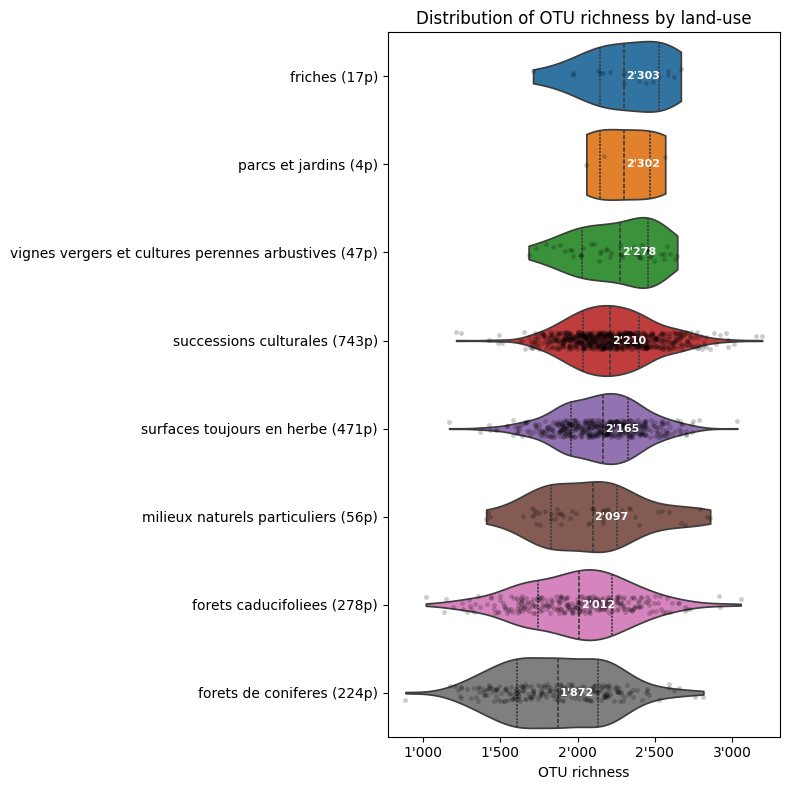

In [15]:
# order categories by median richness (descending)
medians = result_df.groupby('land_use')['otu_richness'].median().sort_values(ascending=False)
order = medians.index.tolist()

# portrait figure (taller than wide) — height scales with number of categories
fig_w, fig_h = 8, max(8, 0.35 * len(order))
fig, ax = plt.subplots(figsize=(fig_w, fig_h))

# thicker violins: increase width and linewidth, remove inner to avoid clutter
sns.violinplot(x='otu_richness', y='land_use', data=result_df,
               order=order, inner='quartile', scale='width', cut=0, palette='tab10')

# jittered points overlay (show individual sites) — use slightly larger points and semi-transparent
sns.stripplot(x='otu_richness', y='land_use', data=result_df,
              order=order, color='k', size=3.5, jitter=True, alpha=0.2, ax=ax)

# compute medians and annotate them next to the median markers
offset = max(medians.max() * 0.005, 0.5)  # horizontal offset for labels
fmt = lambda x, pos=None: f"{x:,.0f}".replace(',', "'") #number format function
for i, (cat, med) in enumerate(medians.items()):
    ax.text(med + offset, i, fmt(med), va='center', ha='left', fontsize=8, fontweight='bold', color='white')

# formatting
# counts per category for labels
counts = result_df.groupby('land_use').size().reindex(order).fillna(0).astype(int)
y_labels = [f"{cat} ({cnt}p)" for cat, cnt in zip(order, counts)]
ax.set_yticks(range(len(order)))
ax.set_yticklabels(y_labels)
ax.set_xlabel('OTU richness')
ax.set_ylabel('')
ax.set_title('Distribution of OTU richness by land‑use')

fmt = lambda x, pos: f"{x:,.0f}".replace(',', "'")
ax.xaxis.set_major_formatter(FuncFormatter(fmt))

plt.tight_layout()
out_path = r"c:\Users\aburg\Documents\calculations\rmqs_exploration\results\otu_richness_by_land_use_violin.png"
plt.savefig(out_path, dpi=300)
plt.show()

In [16]:
pivot = meta_sel.groupby(['desc_code_occupation1', 'desc_code_occupation3']).size().rename('count').to_frame()

print(pivot)

                                                                                                   count
desc_code_occupation1                          desc_code_occupation3                                    
friches                                        friches                                                20
milieux naturels particuliers                  dunes cotieres et plages de sable                       3
                                               fruticees sclerophylles (maquis, garrigue)             10
                                               landes et fruticees                                    11
                                               landes, fruticees et prairies naturelles                1
                                               marais sales, pres sales (schorres), steppes sales      3
                                               milieux littoraux et halophiles                         2
                                               milieux 